# Modelos de Machine Learning y series temporales
Este Jupyter Notebook se encarga de seleccionar, entrenar y testear los modelos de ML y series temporales que se han considerado más adecuados para predecir 100 periodos de tiempos en el futuro con la particularidad de que a partir del isntante donde se iniia la predicción, no se dispone de los valores de las variables regresoras.

Partimos del dataset preprocesado en el script 'load_dataset.ipynb', donde se realizaron todas las comprobaciones y ajustes necesarios para realizar las predicciones de nuestra variable objetivo 'BIODIESEL'.

## Carga y preparación de los datos

#### Importación de bibliotecas necesarias

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import xgboost as xgb
from sklearn.model_selection import train_test_split

#### Carga de datos

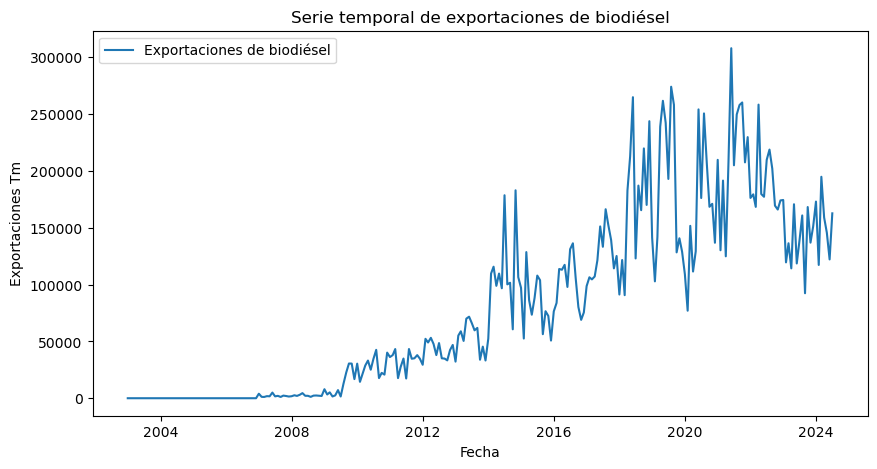

In [10]:
data = pd.read_csv("dataset4regression.csv", parse_dates=['Fecha'], index_col='Fecha')
data_biodiesel = data[data['Tipo Producto'] == 'BIODIESEL']

# Visualización inicial
plt.figure(figsize=(10, 5))
plt.plot(data_biodiesel.index, data_biodiesel['Exportaciones Tm'], label='Exportaciones de biodiésel')
plt.title('Serie temporal de exportaciones de biodiésel')
plt.xlabel('Fecha')
plt.ylabel('Exportaciones Tm')
plt.legend()
plt.show()

## Modelado con ARIMA

### ARIMA (AutoRegressive Integrated Moving Average)
Adecuado cuando la serie presenta patrones de tendencia y no es estacionaria en su forma original, pero no tiene estacionalidad fuerte o periódica que varíe con el tiempo, como es nuestro caso.

Para determinar los valores óptimos de p, d y q que necesita el modelo ARIMA para ser entrenado, generalmente utilizamos gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF), así como una evaluación de la estacionariedad de la serie. El valor d (número de diferenciaciones necesarias) generalmente es 1 o 2, por lo que utilizaremos estos valores.

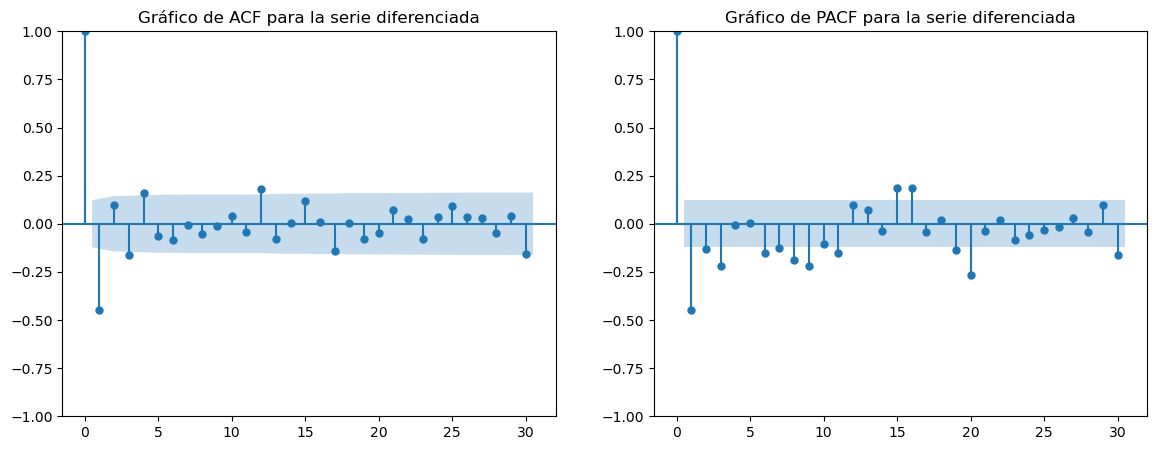

In [11]:
# Realizamos la diferenciación para hacer la serie estacionaria
diff_series = data_biodiesel['Exportaciones Tm'].diff().dropna()

# Graficamos ACF y PACF para la serie diferenciada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(diff_series, ax=ax1, lags=30)
plot_pacf(diff_series, ax=ax2, lags=30)
ax1.set_title('Gráfico de ACF para la serie diferenciada')
ax2.set_title('Gráfico de PACF para la serie diferenciada')
plt.show()

En el gráfico de ACF observamos que la autocorrelación en el lag 1 es significativa y negativa, pero además también tenemos otros picos significativos en los lags 2, 4, y 5 (que están fuera del área sombreada). De la misma forma, en el gráfico de PACF, el primer lag es significativamente positivo y también se observan picos significativos en lags 2, 3, y 4, que se encuentran fuera del área sombreada.

Como la primera diferenciación no deja claro que la serie sea completamente estacionaria, podemos aplicar una segunda diferenciación y analizar nuevamente los gráficos de ACF y PACF. Esto es común en series temporales donde persisten tendencias residuales o patrones cíclicos después de la primera diferenciación.

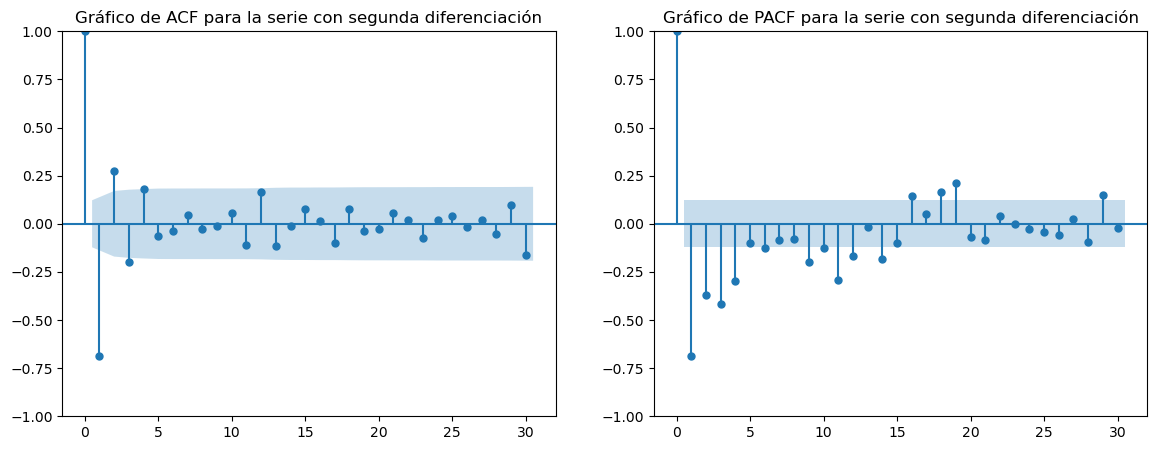

In [12]:
# Realizar una segunda diferenciación para hacer la serie estacionaria
second_diff_series = data_biodiesel['Exportaciones Tm'].diff().diff().dropna()

# Graficar ACF y PACF para la serie con segunda diferenciación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(second_diff_series, ax=ax1, lags=30)
plot_pacf(second_diff_series, ax=ax2, lags=30)
ax1.set_title('Gráfico de ACF para la serie con segunda diferenciación')
ax2.set_title('Gráfico de PACF para la serie con segunda diferenciación')
plt.show()

En el gráfico de ACF, observamos un pico negativo en el primer, segundo y tercer lag, y algunos otros picos menores. Sin embargo, la mayoría de los puntos se encuentran dentro del intervalo de confianza. En el gráfico de PACF, se observa un pico en el primer, segundo, tercero, cuarto y quinto lag. Después, la mayoría de los valores caen dentro del intervalo de confianza, aunque de forma menos clara que en el ACF.

Con base en esto, podemos suponer que q (orden de la media móvil) podría ser 3, dado que el efecto significativo se reduce después de los primeros tres lags. De la misma forma, el PACF sugiere que p (orden autoregresivo) podría estar entorno a 5. Como ahora las series parecen ser más estacionarias, el valor d=2 por haber utilizado una segunda diferenciación.

c:\Users\rtx11679\AppData\Local\anaconda3\envs\env2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rtx11679\AppData\Local\anaconda3\envs\env2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\rtx11679\AppData\Local\anaconda3\envs\env2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE: 51099.78308384903
RMSE: 67734.71585578106


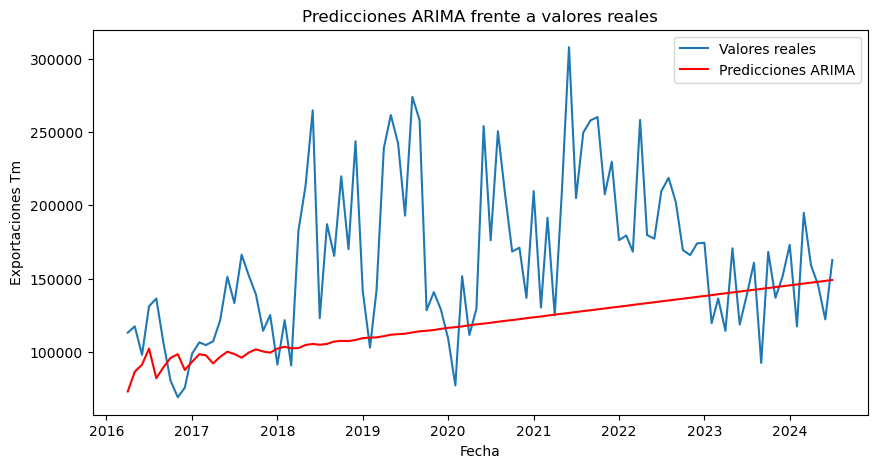

In [22]:
# Dividimos los datos en entrenamiento y prueba
train = data_biodiesel['Exportaciones Tm'][:-100]
test = data_biodiesel['Exportaciones Tm'][-100:]

# Entrenamos el modelo ARIMA con los valores p, d y q
model = ARIMA(train, order=(5, 2, 3))
arima_model = model.fit()

# Predicciones
forecast = arima_model.forecast(steps=100)

# Calculamos las métricas de error
mae = mean_absolute_error(test, forecast)
rmse = root_mean_squared_error(test, forecast)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Visualizamos las predicciones
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Valores reales')
plt.plot(test.index, forecast, label='Predicciones ARIMA', color='red')
plt.title('Predicciones ARIMA frente a valores reales')
plt.xlabel('Fecha')
plt.ylabel('Exportaciones Tm')
plt.legend()
plt.show()

Tras probar con varios valores de p, d y q, los resultados obtenidos no son los esperados. Las predicciones no se ajustan en gran medida a los valores reales, aunque al final sí parece haber unas predicciones más finas y adecuadas.

## Modelado con XGBoost
Extreme Gradient Boosting es un algoritmo de aprendizaje supervisado basado en árboles de decisión que emplea una técnica de boosting para mejorar la precisión de las predicciones.

XGBoost es particularmente eficaz en capturar patrones complejos y no lineales en los datos, algo que puede ser útil para las series temporales con fluctuaciones y tendencias inestables de nuestro caso de estudio. Además, el modelo permite ajustar parámetros de regularización (como lambda y alpha), lo cual ayuda a reducir el sobreajuste y produce modelos más generalizables.

MAE: 50191.55203125
RMSE: 61081.73261098321


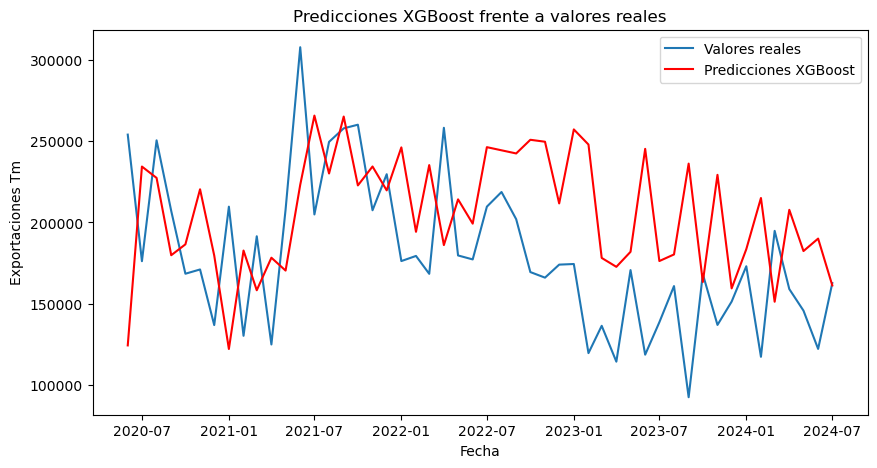

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Definimos la función de error actualizado
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Preparación de los datos
def create_lagged_features(data, lag=12):
    """
    Crea características de rezagos para un modelo de series temporales.
    :param data: Serie temporal original
    :param lag: Número de rezagos a crear
    :return: DataFrame con las características de rezagos
    """
    df = data.copy().to_frame()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Exportaciones Tm'].shift(i)
    df.dropna(inplace=True)
    return df

# Creamos características de rezago (por ejemplo, 12 meses)
lagged_data = create_lagged_features(data_biodiesel['Exportaciones Tm'], lag=12)

# Dividimos en datos de entrenamiento y prueba
train_size = int(len(lagged_data) * 0.8)
train, test = lagged_data.iloc[:train_size], lagged_data.iloc[train_size:]

# Separamos características y etiquetas
X_train, y_train = train.drop(columns=['Exportaciones Tm']), train['Exportaciones Tm']
X_test, y_test = test.drop(columns=['Exportaciones Tm']), test['Exportaciones Tm']

# Configuramos y entrenamos el modelo XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Para regresión
    n_estimators=100,
    max_depth=3,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Realizamos predicciones
y_pred = xgb_model.predict(X_test)

# Calculamos métricas de error
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Visualizamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones XGBoost', color='red')
plt.title('Predicciones XGBoost frente a valores reales')
plt.xlabel('Fecha')
plt.ylabel('Exportaciones Tm')
plt.legend()
plt.show()

#### Análisis de resultados del modelo XGBoost
Observamos que las predicciones de XGBoost siguen la tendencia general de los valores reales, aunque muestran fluctuaciones. La línea de predicciones (en rojo) captura algunos picos y caídas en los datos reales, pero en otros puntos no sigue los movimientos con precisión. 

Los valores de MAE y RMSE sugieren que aún tenemos errores significativos en las predicciones en algunos puntos de la serie temporal, pero podemos ver que el modelo se ajusta de forma bastante decente.

En general, XGBoost ha capturado algunos patrones de la serie temporal, pero ajustes adicionales podrían mejorar la precisión del modelo y reducir los errores representados por el MAE y el RMSE.

#### Posibles mejoras:
Un proceso de búsqueda de hiperparámetros (como Grid Search o Random Search) podría ayudar a encontrar la combinación óptima.

Otros modelos como Random Forest o LSTM (Long Short-Term Memory), que están diseñados para manejar series temporales, también podrían ofrecer mejoras.